# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import scipy.ndimage as ndimage
from keras.preprocessing.image import ImageDataGenerator,array_to_img
import pandas as pd
import numpy as np
import seaborn
from PIL import Image
from keras.utils.vis_utils import plot_model
from packaging import version
import io
import tensorboard
import os
from glob import glob

Uncomment the following code cell if running on Google Colab.
The link to download the dataset is included in this cell.

In [2]:
# import sys
# !curl -O https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/download
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

### Global variables

You will need to change the PATH variable to point to the unzipped folder COVID-19_Radiography_Dataset

In [3]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]

### Load the images

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=133,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=133,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


# DATA ANALYSIS

In this dataset, the chest x-ray images are divided into four classes:

In [6]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


The number of images in each class, however, is not evenly distrubuted, as can be seen in the following tables and graph. The biggest difference is between 'Viral Pneumonia' and 'Normal', where the latter has almost eight times as many instances as the former.

In [7]:
# # Get all training and validation labels and put them into separate lists
# # NOTE This can take a while
training_labels = np.concatenate([y for x, y in train_ds], axis=0)
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [8]:
# Use pandas to store the image count of each class in the training set
unique, counts = np.unique(training_labels, return_counts=True)
train_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])
# Do the same for validation set
unique, counts = np.unique(validation_labels, return_counts=True)
val_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])

print('Distribution of training data:\n')
print(train_df)
print('\n\nDistribution of validation data:\n')
print(val_df)

Distribution of training data:

             class  image count
0            COVID         2883
1     Lung Opacity         4869
2           Normal         8103
3  Viral Pneumonia         1077


Distribution of validation data:

             class  image count
0            COVID          733
1     Lung Opacity         1143
2           Normal         2089
3  Viral Pneumonia          268


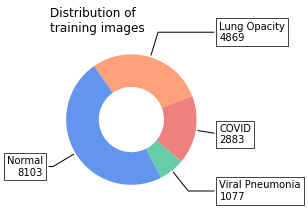

In [9]:
def display_distribution_donut(data_frame):
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"))

    categories = data_frame['class']
    img_count = data_frame['image count']

    wedges, texts = ax.pie(
        img_count, 
        wedgeprops=dict(width=0.5), 
        startangle=-40, 
        colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{categories[i]}\n{img_count[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.title("Distribution of\ntraining images", loc='left')
    plt.show()

display_distribution_donut(train_df)

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 128, 128, 1)
(32,)


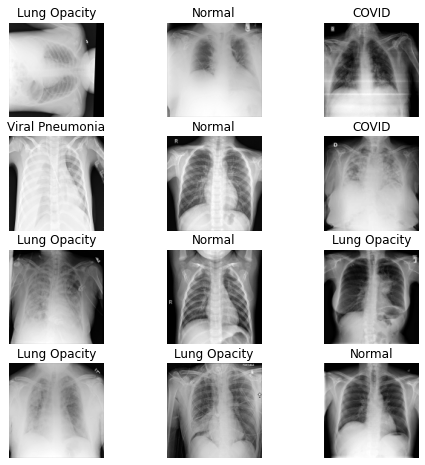

In [11]:
plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

# IMAGE PREPROCESSING

## Remove the diaphram from the images (the lower, bright area)

In [12]:
def segment_diaphram(images):
    # If blurred pixel-value is greater than 195, make it black; otherwise, do not alter
    # NOTE The commented out code below does a decent job, but threshold applies to entire batch
    # blurred_images = ndimage.gaussian_filter(images, sigma=3)
    # images = tf.where(blurred_images > 195, 0, images) 

    alist_images = []
    for img in images:
        blurred_image = ndimage.gaussian_filter(img, sigma=3)
        minimum, maximum, _, _ = ndimage.extrema(blurred_image)
        threshold = int((maximum - minimum) * 0.95 + minimum)
        img = tf.where(blurred_image > threshold, 16, img)
        alist_images.append(img)
    stack_of_imgs = np.stack(alist_images, axis=0)
    return stack_of_imgs

def tf_segment_diaphram(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(segment_diaphram, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds = train_ds.map(tf_segment_diaphram)

## Add randomly altered images to the training dataset

In [13]:
def reshape_image(image):
    image = tf.image.random_brightness(image, max_delta=.5)
    image = tf.image.random_contrast(image, .3, 1.7)
    image = tf.image.random_flip_left_right(image)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=3, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

def tf_reshape_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(reshape_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds_reshaped = train_ds.map(tf_reshape_image)
train_ds = train_ds.concatenate(train_ds_reshaped)
train_ds.shuffle(buffer_size=len(train_ds)*BATCH_SIZE)

<ShuffleDataset shapes: ((None, 128, 128, 1), (None,)), types: (tf.float32, tf.int32)>

### Displaying some newly altered images

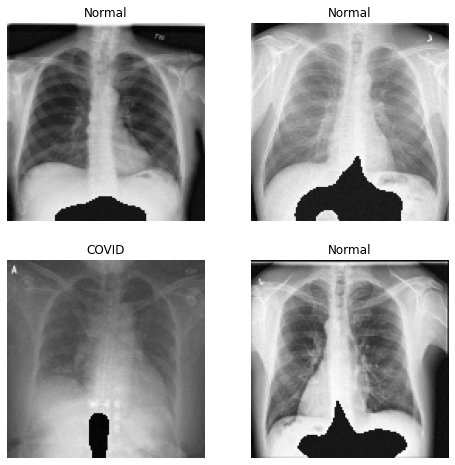

In [57]:
def show(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(CLASS_NAMES[label])
    plt.axis('off')

plt.figure(figsize=(8, 8))
for images, labels in train_ds_reshaped.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        img = images[i]
        img_gray = img[:,:,0]
        show(img_gray, labels[i])

## Using keras to add more random variation to the training set

In [15]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              1)),
    # layers.experimental.preprocessing.RandomRotation(0.01),
    # layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Display some changes that Keras made to the training set

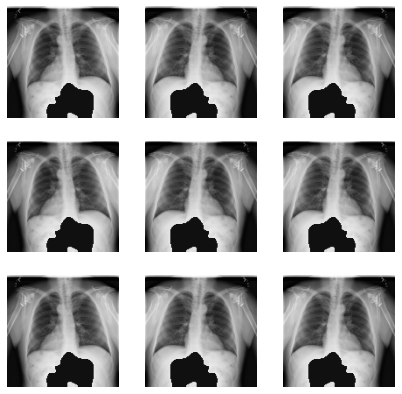

In [64]:
plt.figure(figsize=(7, 7))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        aug_img_gray = augmented_images[0,:,:,0]
        plt.imshow(aug_img_gray.numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# CLASSIFICATION

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()
# plot_model(model, to_file='./graphs/model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)      

In [20]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1060/1060 [==============================] - 136s 128ms/step - loss: 0.7457 - accuracy: 0.6921 - val_loss: 0.5470 - val_accuracy: 0.7914
Epoch 2/10
1060/1060 [==============================] - 128s 121ms/step - loss: 0.4312 - accuracy: 0.8351 - val_loss: 0.5156 - val_accuracy: 0.8141
Epoch 3/10
1060/1060 [==============================] - 127s 120ms/step - loss: 0.3395 - accuracy: 0.8734 - val_loss: 0.4476 - val_accuracy: 0.8408
Epoch 4/10
1060/1060 [==============================] - 125s 118ms/step - loss: 0.2689 - accuracy: 0.8986 - val_loss: 0.4494 - val_accuracy: 0.8472
Epoch 5/10
1060/1060 [==============================] - 125s 118ms/step - loss: 0.2337 - accuracy: 0.9124 - val_loss: 0.4258 - val_accuracy: 0.8649
Epoch 6/10
1060/1060 [==============================] - 124s 117ms/step - loss: 0.2041 - accuracy: 0.9254 - val_loss: 0.5068 - val_accuracy: 0.8623
Epoch 7/10
1060/1060 [==============================] - 127s 120ms/step - loss: 0.1798 - accuracy: 0.9338 - val_

# RESULTS

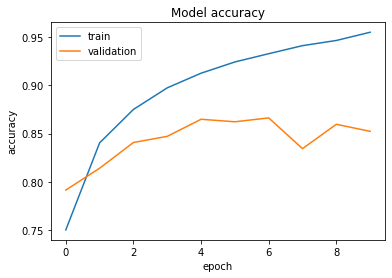

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

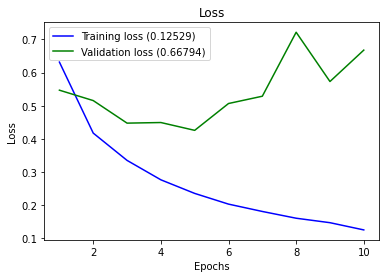

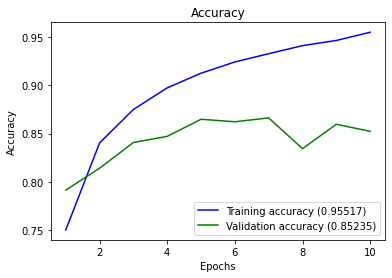

In [22]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    # As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    # Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(hist)


                  precision    recall  f1-score   support

          COVID       0.85      0.79      0.82       733
   Lung Opacity       0.80      0.83      0.82      1143
         Normal       0.87      0.88      0.88      2089
Viral Pneumonia       0.93      0.85      0.89       268

       accuracy                           0.85      4233
      macro avg       0.86      0.84      0.85      4233
   weighted avg       0.85      0.85      0.85      4233



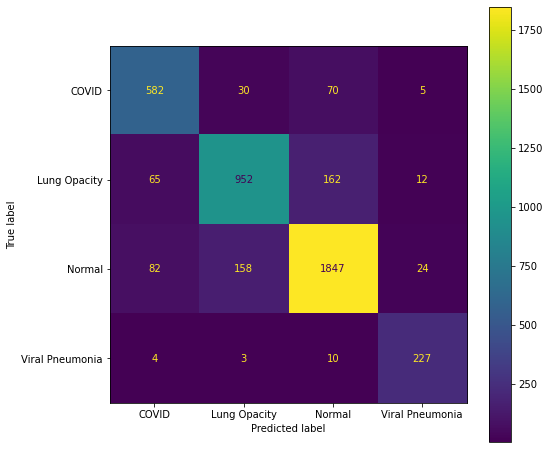

In [23]:
def validation_data_categories(test_images):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(8,8))
    display.plot(ax=ax)

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

In [24]:
# Save the model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop_big.h5')

# TESTING ON OUTSIDE DATA

This image is COVID with 95.27% confidence


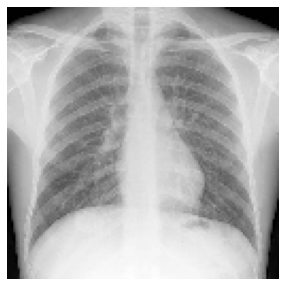

In [65]:
test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
# test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"
# test_image_path = "/Users/jeremygaudet/Desktop/Screen Shot 2021-04-23 at 9.28.57 AM.png"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis("off")

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

In [34]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './test_set',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=17,
    label_mode="int",
    color_mode="grayscale"
)

Found 60 files belonging to 3 classes.



                  precision    recall  f1-score   support

          COVID       0.00      0.00      0.00        20
   Lung Opacity       1.00      0.05      0.10        20
         Normal       0.25      0.25      0.25        20
Viral Pneumonia       0.00      0.00      0.00         0

       accuracy                           0.10        60
      macro avg       0.31      0.07      0.09        60
   weighted avg       0.42      0.10      0.12        60

/Users/jeremygaudet/miniforge3/envs/tf24/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeremygaudet/miniforge3/envs/tf24/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in label

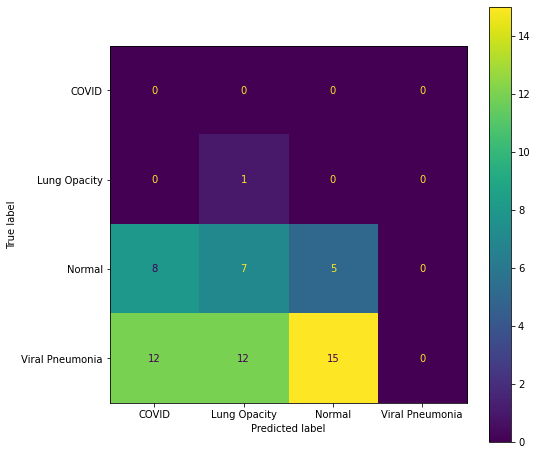

In [35]:
true_cat, pred_cat = validation_data_categories(test_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

# APPENDIX

This code was used to create some graphs in the report. It does not need to be run.

In [28]:
# amount0 = {}
# amount1 = {}
# amount2 = {}
# amount3 = {}
# for img, label in train_ds:
# #  print(features[0])
#     for i in range(len(label)):
#         # flat_img = img[i].numpy().flatten()
#         # print(flat_img)
#         # print(len(flat_img))
#         # print(len(label))
#         avg = int(np.average(img[i]))
#         # avg = int(np.sum(flat_img) / len(flat_img))
#         # print(label)
#         if label[i] == 0:
#             if avg not in amount0:
#                 amount0[avg] = 1
#             else:
#                 amount0[avg] += 1
#         elif label[i] == 1:
#             if avg not in amount1:
#                 amount1[avg] = 1
#             else:
#                 amount1[avg] += 1
#         elif label[i] == 2:
#             if avg not in amount2:
#                 amount2[avg] = 1
#             else:
#                 amount2[avg] += 1
#         elif label[i] == 3:
#             if avg not in amount3:
#                 amount3[avg] = 1
#             else:
#                 amount3[avg] += 1

# sorted_dict0 = dict(sorted(amount0.items()))
# sorted_dict1 = dict(sorted(amount1.items()))
# sorted_dict2 = dict(sorted(amount2.items()))
# sorted_dict3 = dict(sorted(amount3.items()))

# plt.figure(figsize=(10,10))
# plt.plot(sorted_dict0.keys(), sorted_dict0.values(), 'red', label=CLASS_NAMES[0])
# plt.plot(sorted_dict1.keys(), sorted_dict1.values(), 'blue', label=CLASS_NAMES[1])
# plt.plot(sorted_dict2.keys(), sorted_dict2.values(), 'green', label=CLASS_NAMES[2])
# plt.plot(sorted_dict3.keys(), sorted_dict3.values(), 'black', label=CLASS_NAMES[3])
# plt.legend()
# plt.show()